<a href="https://colab.research.google.com/github/Peiprjs/voila/blob/main/HIV_Deaths_VS_Total_expenditure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HIV deaths in 0-4 year-old children against total healthcare expenditure in South Africa and the Netherlands
### A project by Ellie Petrova (i6326413) and Mar Roca (i6351071)
An alternative and likely complementary hypothesis points to the widespread use of unsafe medical practices in Africa during years following World War II, such as unsterile reuse of single-use syringes during mass vaccination, antibiotic, and anti-malaria treatment campaigns

In [ ]:
import pandas as pd
healthFactors = pd.read_csv('https://raw.githubusercontent.com/NHameleers/dtz2025-datasets/master/CountryHealthFactors.csv')
# This imports both Panda and the CSV with the dataset
hf_SouthAfrica = healthFactors.loc[healthFactors.Country == "South Africa", ['Year', 'Total expenditure', ' HIV/AIDS']]
hf_Netherlands = healthFactors.loc[healthFactors.Country == "Netherlands", ['Year', 'Total expenditure', ' HIV/AIDS']]
# This selects only the data that we're interested in: Years, Total expenditure and HIV/AIDS (note the leading space)
# from rows which Country column is equal to South Africa and the Netherlands respectively.

In [34]:
print(f"The datasets have both the same shape: {hf_SouthAfrica.shape}")
print(f"The data that we have was collected between {hf_SouthAfrica.Year.min()} and {hf_Netherlands.Year.max()}")

The datasets have the same shape: (16, 3)
The data that we have was collected between 2000 and 2015


By running `hf_SouthAfrica.shape` and `hf_Netherlands.shape` we get the shapes of the dataframes resulting from isolating the data that we are interested in. We can observe that both of the resulting frames have a shape of 16x3: 16 rows and 3 columns. By running `hf_SouthAfrica.Year.min()` and `hf_SouthAfrica.Year.max()` we can find out between what years do we have data.

# In South Africa throughout the years (insert years)


In [6]:
hf_SouthAfrica.head()
# This selects only the columns and rows we're interested in: Years, Total expenditure and HIV/AIDS (note the leading space) from rows which Country column is equal to South Africa

,Year,Total expenditure,HIV/AIDS
2393,2015,NaN,3.6
2394,2014,8.80,3.7
2395,2013,8.78,4.5
2396,2012,8.79,7.6
2397,2011,8.61,8.5


## TEMPORARY graphs (integrate into code before submission)

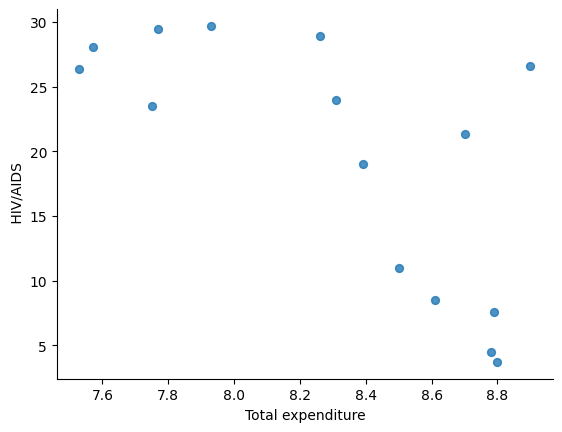

In [ ]:
# @title Total expenditure vs  HIV/AIDS

from matplotlib import pyplot as plt
hf_SouthAfrica.plot(kind='scatter', x='Total expenditure', y=' HIV/AIDS', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

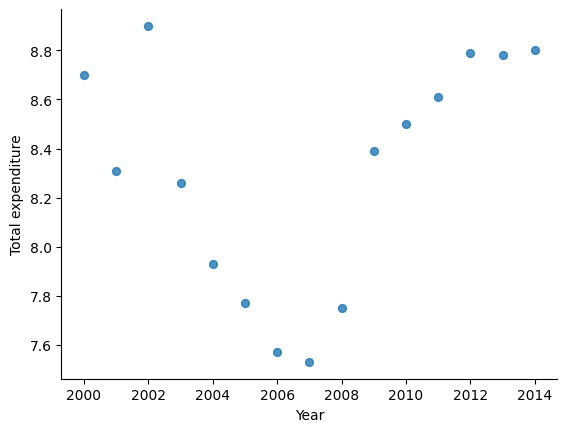

In [ ]:
# @title Year vs Total expenditure

from matplotlib import pyplot as plt
hf_SouthAfrica.plot(kind='scatter', x='Year', y='Total expenditure', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

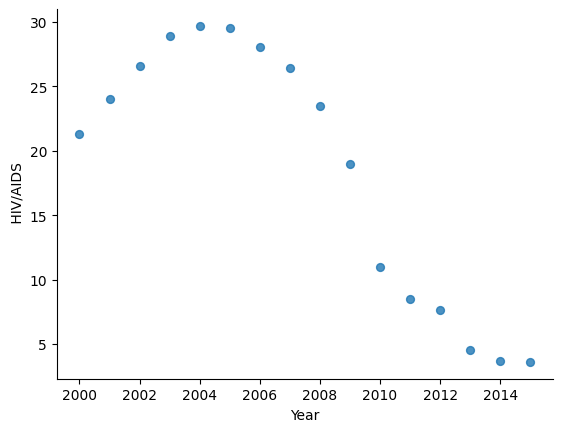

In [ ]:
# @title Year vs  HIV/AIDS

from matplotlib import pyplot as plt
hf_SouthAfrica.plot(kind='scatter', x='Year', y=' HIV/AIDS', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Comparing South Africa and The Netherlands in [year]



,Year,Total expenditure,HIV/AIDS
1829,2015,NaN,0.1
1830,2014,1.90,0.1
1831,2013,11.40,0.1
1832,2012,11.10,0.1
1833,2011,1.53,0.1
